<a href="https://colab.research.google.com/github/zaellis/ECE6254_final_project/blob/main/ECE6254_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE6254 Final Project
|Colaborators|||
|--------------|---------------|---------|
|Zachary Ellis | Daniel Jacobs | Amy Yao |

## Description

For our final project in ECE6254 at Georgia Tech we decided to investigate Google's [scaaml](https://github.com/google/scaaml) repository which demonstrates a machine learning assited side-channel attack on the TinyAES peripheral in the stm32f415 microcontroller. We investigate the performance of these pretrained models on different attack vectors and do some anaylsis on their performance.

## Retrieve the scaaml repo

In [1]:
!git clone https://github.com/google/scaaml.git scaaml_git

fatal: destination path 'scaaml_git' already exists and is not an empty directory.


## Download Models and Datasets and Unzip

In [2]:
%cd /content/scaaml_git/scaaml_intro/
!wget -v -N https://storage.googleapis.com/scaaml-public/scaaml_intro/datasets.zip https://storage.googleapis.com/scaaml-public/scaaml_intro/models.zip
import os.path
if(not os.path.isdir("models/")):
  !unzip models.zip
if(not os.path.isdir("datasets/")):
  !unzip datasets.zip

/content/scaaml_git/scaaml_intro
--2023-04-05 21:39:43--  https://storage.googleapis.com/scaaml-public/scaaml_intro/datasets.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.31.128, 142.251.18.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.31.128|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘datasets.zip’ not modified on server. Omitting download.

--2023-04-05 21:39:43--  https://storage.googleapis.com/scaaml-public/scaaml_intro/models.zip
Reusing existing connection to storage.googleapis.com:443.
HTTP request sent, awaiting response... 304 Not Modified
File ‘models.zip’ not modified on server. Omitting download.



## Run setup.py

In [3]:
%cd /content/scaaml_git/
!python setup.py develop
%cd /content/scaaml_git/scaaml_intro/

/content/scaaml_git
/usr/local/lib/python3.9/dist-packages/setuptools/dist.py:547: UserWarning: Normalizing '2.0.1r1680730787' to '2.0.1.post1680730787'
  warnings.warn(tmpl.format(**locals()))
running develop
/usr/local/lib/python3.9/dist-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running egg_info
writing scaaml.egg-info/PKG-INFO
writing dependency_links to scaaml.egg-info/dependency_links.txt
writing requirements to scaaml.egg-info/requires.txt
writing top-level names to scaaml.egg-info/top_level.txt
reading manifest file 'scaaml.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'scaaml.egg-info/SOURCES.txt'
running build_

## Run Key Recovery Demo for 1 Byte
If this does not work. Go to the `Runtime` tab and click `Restart and run all`

In [4]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
from tqdm.auto import tqdm
from collections import defaultdict
from tensorflow.keras import metrics
from tabulate import tabulate
import matplotlib.pyplot as plt
import sys
sys.path.append("/content/scaaml_git/scaaml")
from scaaml.aes import ap_preds_to_key_preds
from scaaml.plot import plot_trace, plot_confusion_matrix
from scaaml.utils import tf_cap_memory, from_categorical
from scaaml.model import get_models_by_attack_point, get_models_list, load_model_from_disk
from scaaml.intro.generator import list_shards, load_attack_shard
from scaaml.utils import hex_display, bytelist_to_hex

target = 'stm32f415_tinyaes'
tf_cap_memory()
target_config = json.loads(open("config/" + target + '.json').read())
BATCH_SIZE = target_config['batch_size']
TRACE_LEN = target_config['max_trace_len']


available_models = get_models_by_attack_point(target_config)

DATASET_GLOB = "datasets/%s/test/*" % target_config['algorithm']
shard_paths  = list_shards(DATASET_GLOB, 256)

Attack point    status      Num available models
--------------  --------  ----------------------
sub_bytes_out   complete                      16
sub_bytes_in    complete                      16
key             complete                      16


In [6]:
#@title Select Attack Point and Key Byte for 1 Byte Test { display-mode: "form" }

# let's select an attack point that have all the needed models -- Key is not a good target: it doesn't work
ATTACK_POINT = 'sub_bytes_in' #@param ["sub_bytes_in", "sub_bytes_out", "key"]

# let's also pick the key byte we want to use SCAAML to recover and load the related model
ATTACK_BYTE = 3 #@param [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] {type:"raw"}

# load model
model = load_model_from_disk(available_models[ATTACK_POINT][ATTACK_BYTE])

## Run Selected Model on 10 Power Traces

In [7]:
NUM_TRACES = 10  # maximum number of traces to use to recover a given key byte. 10 is already overkill
correct_prediction_rank = defaultdict(list)
y_pred = []
y_true = []
model_metrics = {"acc": metrics.Accuracy()}
for shard in tqdm(shard_paths, desc='Recovering bytes', unit='shards'):
    keys, pts, x, y = load_attack_shard(shard, ATTACK_BYTE, ATTACK_POINT, TRACE_LEN, num_traces=NUM_TRACES)

    # prediction
    predictions = model.predict(x)
    
    # computing byte prediction from intermediate predictions
    key_preds = ap_preds_to_key_preds(predictions, pts, ATTACK_POINT)
    
    c_preds = from_categorical(predictions)
    c_y = from_categorical(y)
    # metric tracking
    for metric in model_metrics.values():
        metric.update_state(c_y, c_preds)
    # for the confusion matrix
    y_pred.extend(c_preds)
    y_true.extend(c_y)
    
    # accumulating probabilities and checking correct guess position.
    # if all goes well it will be at position 0 (highest probability)
    # see below on how to use for the real attack
    
    
    key = keys[0] # all the same in the same shard - not used in real attack
    vals = np.zeros((256))
    for trace_count, kp in enumerate(key_preds):
        vals = vals  + np.log10(kp + 1e-22) 
        guess_ranks = (np.argsort(vals, )[-256:][::-1])
        byte_rank = list(guess_ranks).index(key)
        correct_prediction_rank[trace_count].append(byte_rank)

Recovering bytes:   0%|          | 0/256 [00:00<?, ?shards/s]

1/1 [==============================] - 1s 536ms/step


## Print Metrics

Accuracy: 0.49


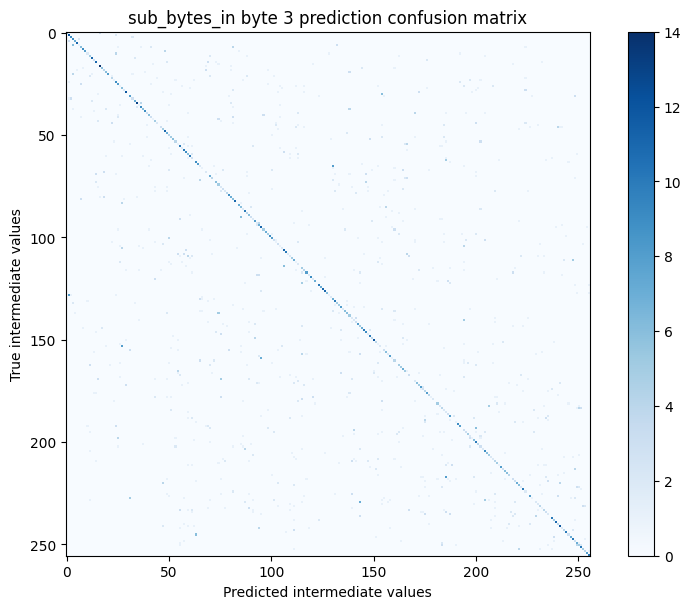

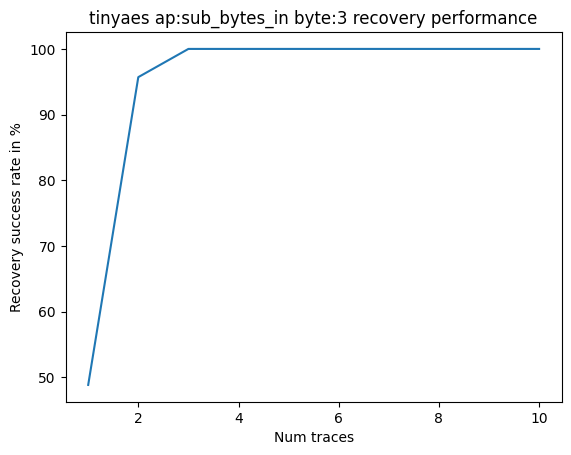

metric              num traces  % of keys
----------------  ------------  -----------
min traces                1     48.8
max traces                3     100.0
cumulative score         81.51  -


In [8]:
print("Accuracy: %.2f" % model_metrics['acc'].result())


plot_confusion_matrix(y_true, y_pred, normalize=True, title="%s byte %s prediction confusion matrix" % (ATTACK_POINT, ATTACK_BYTE))

NUM_TRACES_TO_PLOT = 10
avg_preds = np.array([correct_prediction_rank[i].count(0) for i in range(NUM_TRACES_TO_PLOT)])
y = avg_preds / len(correct_prediction_rank[0]) * 100 
x = [i + 1 for i in range(NUM_TRACES_TO_PLOT)]
plt.plot(x, y)
plt.xlabel("Num traces")
plt.ylabel("Recovery success rate in %")
plt.title("%s ap:%s byte:%s recovery performance" % (target_config['algorithm'], ATTACK_POINT, ATTACK_BYTE))
plt.show()

min_traces = 0
max_traces = 0
cumulative_aa = 0
for idx, val in enumerate(y):
    cumulative_aa += val
    if not min_traces and val > 0:
        min_traces = idx + 1
    if not max_traces and val == 100.0:
        max_traces = idx + 1
        break 

cumulative_aa = round( cumulative_aa / (idx + 1), 2) # divide by the number of steps

rows = [
    ["min traces", min_traces, round(y[min_traces -1 ], 1)],
    ["max traces", max_traces, round(y[max_traces - 1], 1)],
    ["cumulative score", cumulative_aa, '-'] 
]
print(tabulate(rows, headers=['metric', 'num traces', '% of keys']))